*Note: You are currently reading this using Google Colaboratory which is a cloud-hosted version of Jupyter Notebook. This is a document containing both text cells for documentation and runnable code cells. If you are unfamiliar with Jupyter Notebook, watch this 3-minute introduction before starting this challenge: https://www.youtube.com/watch?v=inN8seMm7UI*

---

In this challenge, you will create a book recommendation algorithm using **K-Nearest Neighbors**.

You will use the [Book-Crossings dataset](http://www2.informatik.uni-freiburg.de/~cziegler/BX/). This dataset contains 1.1 million ratings (scale of 1-10) of 270,000 books by 90,000 users. 

After importing and cleaning the data, use `NearestNeighbors` from `sklearn.neighbors` to develop a model that shows books that are similar to a given book. The Nearest Neighbors algorithm measures distance to determine the “closeness” of instances.

Create a function named `get_recommends` that takes a book title (from the dataset) as an argument and returns a list of 5 similar books with their distances from the book argument.

This code:

`get_recommends("The Queen of the Damned (Vampire Chronicles (Paperback))")`

should return:

```
[
  'The Queen of the Damned (Vampire Chronicles (Paperback))',
  [
    ['Catch 22', 0.793983519077301], 
    ['The Witching Hour (Lives of the Mayfair Witches)', 0.7448656558990479], 
    ['Interview with the Vampire', 0.7345068454742432],
    ['The Tale of the Body Thief (Vampire Chronicles (Paperback))', 0.5376338362693787],
    ['The Vampire Lestat (Vampire Chronicles, Book II)', 0.5178412199020386]
  ]
]
```

Notice that the data returned from `get_recommends()` is a list. The first element in the list is the book title passed in to the function. The second element in the list is a list of five more lists. Each of the five lists contains a recommended book and the distance from the recommended book to the book passed in to the function.

If you graph the dataset (optional), you will notice that most books are not rated frequently. To ensure statistical significance, remove from the dataset users with less than 200 ratings and books with less than 100 ratings.

The first three cells import libraries you may need and the data to use. The final cell is for testing. Write all your code in between those cells.

In [ ]:
# import libraries (you may add additional imports but you may not have to)
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

In [ ]:
# get data files
!wget https://cdn.freecodecamp.org/project-data/books/book-crossings.zip

!unzip book-crossings.zip

books_filename = 'BX-Books.csv'
ratings_filename = 'BX-Book-Ratings.csv'

--2022-03-31 17:03:40--  https://cdn.freecodecamp.org/project-data/books/book-crossings.zip
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 172.67.70.149, 104.26.2.33, 104.26.3.33, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|172.67.70.149|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26085508 (25M) [application/zip]
Saving to: ‘book-crossings.zip’

book-crossings.zip  100%[===================>]  24.88M  36.9MB/s    in 0.7s    

2022-03-31 17:03:41 (36.9 MB/s) - ‘book-crossings.zip’ saved [26085508/26085508]

Archive:  book-crossings.zip
  inflating: BX-Book-Ratings.csv     
  inflating: BX-Books.csv            
  inflating: BX-Users.csv            


In [ ]:
# import csv data into dataframes
df_books = pd.read_csv(
    books_filename,
    encoding = "ISO-8859-1",
    sep=";",
    header=0,
    names=['isbn', 'title', 'author'],
    usecols=['isbn', 'title', 'author'],
    dtype={'isbn': 'str', 'title': 'str', 'author': 'str'})

df_ratings = pd.read_csv(
    ratings_filename,
    encoding = "ISO-8859-1",
    sep=";",
    header=0,
    names=['user', 'isbn', 'rating'],
    usecols=['user', 'isbn', 'rating'],
    dtype={'user': 'int32', 'isbn': 'str', 'rating': 'float32'})

---
# Dataset Info

In [ ]:
df_books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271379 entries, 0 to 271378
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   isbn    271379 non-null  object
 1   title   271379 non-null  object
 2   author  271378 non-null  object
dtypes: object(3)
memory usage: 6.2+ MB


In [ ]:
df_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   user    1149780 non-null  int32  
 1   isbn    1149780 non-null  object 
 2   rating  1149780 non-null  float32
dtypes: float32(1), int32(1), object(1)
memory usage: 17.5+ MB


In [ ]:
df_books.head()

,isbn,title,author
0,0195153448,Classical Mythology,Mark P. O. Morford
1,0002005018,Clara Callan,Richard Bruce Wright
2,0060973129,Decision in Normandy,Carlo D'Este
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata
4,0393045218,The Mummies of Urumchi,E. J. W. Barber


In [ ]:
df_ratings.head()

,user,isbn,rating
0,276725,034545104X,0.0
1,276726,0155061224,5.0
2,276727,0446520802,0.0
3,276729,052165615X,3.0
4,276729,0521795028,6.0


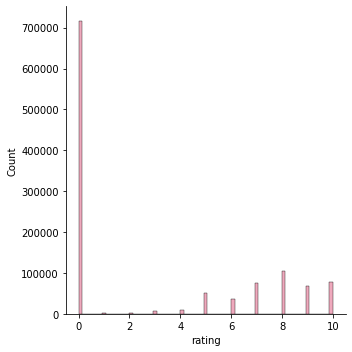

In [ ]:
import seaborn as sns
sns.displot(df_ratings["rating"], color = '#EA8CA7')

---
# Data Preparation

---
+ Removing Users with less than 200 user ratings

In [ ]:
updated_ratings = df_ratings[df_ratings["user"].isin(df_ratings["user"].value_counts()[df_ratings["user"].value_counts() >= 200].index)]

---
+ Removing books with less than 100 user ratings

In [ ]:
updated_ratings = updated_ratings[updated_ratings["isbn"].isin(df_ratings["isbn"].value_counts()[df_ratings["isbn"].value_counts() >= 100].index)]

In [ ]:
df_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   user    1149780 non-null  int32  
 1   isbn    1149780 non-null  object 
 2   rating  1149780 non-null  float32
dtypes: float32(1), int32(1), object(1)
memory usage: 17.5+ MB


In [ ]:
updated_ratings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49781 entries, 1456 to 1147441
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   user    49781 non-null  int32  
 1   isbn    49781 non-null  object 
 2   rating  49781 non-null  float32
dtypes: float32(1), int32(1), object(1)
memory usage: 1.1+ MB


---
+ Making a common table

In [ ]:
resultant = pd.merge(updated_ratings, df_books, on='isbn').drop(["author"], axis = 1)
resultant.head()

,user,isbn,rating,title
0,277427,002542730X,10.0,Politically Correct Bedtime Stories: Modern Ta...
1,3363,002542730X,0.0,Politically Correct Bedtime Stories: Modern Ta...
2,11676,002542730X,6.0,Politically Correct Bedtime Stories: Modern Ta...
3,12538,002542730X,10.0,Politically Correct Bedtime Stories: Modern Ta...
4,13552,002542730X,0.0,Politically Correct Bedtime Stories: Modern Ta...


In [ ]:
resultant.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49517 entries, 0 to 49516
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   user    49517 non-null  int32  
 1   isbn    49517 non-null  object 
 2   rating  49517 non-null  float32
 3   title   49517 non-null  object 
dtypes: float32(1), int32(1), object(2)
memory usage: 1.5+ MB


---
+ Generating matrix between book and user with rating

In [ ]:
resultant = resultant.drop_duplicates(['user', 'title'])
matrix = resultant.pivot(index = 'title', columns = 'user', values = 'rating')
matrix = matrix.fillna(0)
matrix2 = csr_matrix(matrix.values)

---
+ Making model

In [ ]:
model = NearestNeighbors(metric = 'cosine', n_neighbors = 6)
model.fit(matrix2)

NearestNeighbors(metric='cosine', n_neighbors=6)

In [ ]:
matrix.info()

<class 'pandas.core.frame.DataFrame'>
Index: 673 entries, 1984 to \O\" Is for Outlaw"
Columns: 888 entries, 254 to 278418
dtypes: float32(888)
memory usage: 2.3+ MB


---
Test Case
+ [x] The Queen of the Damned (Vampire Chronicles (Paperback))

In [ ]:
# Testing Given Test Case with The Queen of the Damned (Vampire Chronicles (Paperback))
def test(book = ""):
  indices = matrix.index.values
  index = np.where(indices == book)[0][0]
  vectors, books = model.kneighbors(matrix.iloc[index, :].values.reshape(1, -1))
  vectors = vectors.reshape(-1)
  books = books.reshape(-1)
  print(f'Books similar to : {matrix.index[index]}\n')
  list2 = []
  for i in range(1, len(vectors)):
        nestedlist = [matrix.index[books[i]], vectors[i]]
        list2.append(nestedlist)
  list2 = sorted(list2, key=lambda x:x[1], reverse = True)
  for i in list2:
    print(f'Book : {i[0]} \nDistance = {i[1]}\n')
test('The Queen of the Damned (Vampire Chronicles (Paperback))')

Books similar to : The Queen of the Damned (Vampire Chronicles (Paperback))

Book : Catch 22 
Distance = 0.793983519077301

Book : The Witching Hour (Lives of the Mayfair Witches) 
Distance = 0.7448656558990479

Book : Interview with the Vampire 
Distance = 0.7345068454742432

Book : The Tale of the Body Thief (Vampire Chronicles (Paperback)) 
Distance = 0.5376338362693787

Book : The Vampire Lestat (Vampire Chronicles, Book II) 
Distance = 0.5178411602973938



---
+ Output required

```
[
  'The Queen of the Damned (Vampire Chronicles (Paperback))',
  [
    ['Catch 22', 0.793983519077301], 
    ['The Witching Hour (Lives of the Mayfair Witches)', 0.7448656558990479], 
    ['Interview with the Vampire', 0.7345068454742432],
    ['The Tale of the Body Thief (Vampire Chronicles (Paperback))', 0.5376338362693787],
    ['The Vampire Lestat (Vampire Chronicles, Book II)', 0.5178412199020386]
  ]
]
```

---
# Predict

In [ ]:
# function to return recommended books - this will be tested
def get_recommends(book = ""):
  indices = matrix.index.values
  index = np.where(indices == book)[0][0]
  vectors, books = model.kneighbors(matrix.iloc[index, :].values.reshape(1, -1))
  vectors = vectors.reshape(-1)
  books = books.reshape(-1)
  recommended_books = [matrix.index[index]]
  list2 = []
  for i in range(1, len(books)):
        nestedlist = [matrix.index[books[i]], vectors[i]]
        list2.append(nestedlist)
  list2 = sorted(list2, key=lambda x:x[1], reverse = True)
  recommended_books.append(list2[:4]) # Challenge needs 4 books in descending order
  return recommended_books

Use the cell below to test your function. The `test_book_recommendation()` function will inform you if you passed the challenge or need to keep trying.

In [ ]:
books = get_recommends("Where the Heart Is (Oprah's Book Club (Paperback))")
print(books)

def test_book_recommendation():
  test_pass = True
  recommends = get_recommends("Where the Heart Is (Oprah's Book Club (Paperback))")
  if recommends[0] != "Where the Heart Is (Oprah's Book Club (Paperback))":
    test_pass = False
  recommended_books = ["I'll Be Seeing You", 'The Weight of Water', 'The Surgeon', 'I Know This Much Is True']
  recommended_books_dist = [0.8, 0.77, 0.77, 0.77]
  for i in range(2): 
    if recommends[1][i][0] not in recommended_books:
      test_pass = False
    if abs(recommends[1][i][1] - recommended_books_dist[i]) >= 0.05:
      test_pass = False
  if test_pass:
    print("You passed the challenge! 🎉🎉🎉🎉🎉")
  else:
    print("You haven't passed yet. Keep trying!")

test_book_recommendation()

["Where the Heart Is (Oprah's Book Club (Paperback))", [["I'll Be Seeing You", 0.8016211], ['The Weight of Water', 0.77085835], ['The Surgeon', 0.7699411], ['I Know This Much Is True', 0.7677075]]]
You passed the challenge! 🎉🎉🎉🎉🎉
